In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.5.3
1.24.2


# Step1. 데이터 불러오기

In [2]:
data_dir = os.getenv("HOME") + '/aiffel/s_DATA'
tokenizer_name = 'spm'

In [3]:
# train data load
data_dir = os.getenv('HOME')+'/aiffel/s_DATA/pickle' # 파일 경로 지정
data_train_path = data_dir+f"/data_train_{tokenizer_name}_16000_0601.pkl"
data_test_path = data_dir+f"/data_test_{tokenizer_name}_16000_0601.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2504818 entries, 0 to 2994181
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   reg       object
 1   text      object
 2   pair      object
 3   dial      object
 4   eng       object
 5   toks_en   object
 6   toks_dec  object
dtypes: object(7)
memory usage: 152.9+ MB


In [5]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 365916 to 2817872
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       1000 non-null   object
 1   text      1000 non-null   object
 2   pair      1000 non-null   object
 3   dial      1000 non-null   object
 4   eng       1000 non-null   object
 5   toks_en   1000 non-null   object
 6   toks_dec  1000 non-null   object
dtypes: object(7)
memory usage: 62.5+ KB


In [6]:
regs = full_data.reg.unique()

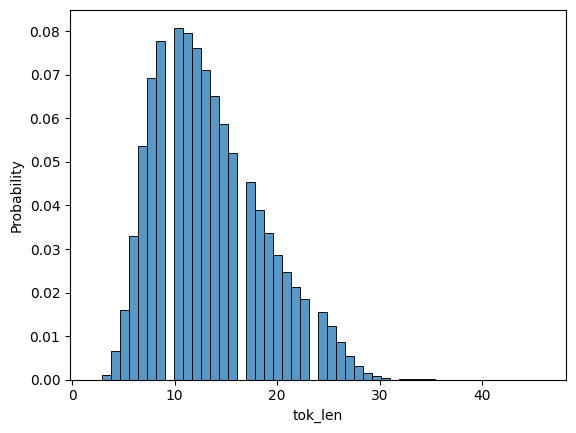

In [7]:
import seaborn as sns
full_data['tok_len'] = full_data['toks_en'].apply(lambda x : len(x))
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [8]:
full_data

,reg,text,pair,dial,eng,toks_en,toks_dec,tok_len
0,jj,그 부주를 하기에는 조금 그렇지 않아?,(안?)/(않아?),그 부주를 하기에는 조금 그렇지 안?,<jj> Isnt it a little bit like that carelessness?,"[50, 4, 221, 12, 11, 26, 79, 18, 17, 295, 1058...","[1, 14, 10161, 37, 8398, 451, 1056, 18, 11, 2]",12
1,jj,그리고 거기서 밥을 먹을지도 모르겠어.,(모르겐.)/(모르겠어.),그리고 거기서 밥을 먹을지도 모르겐.,<jj> And I dont even know if Ill eat rice there.,"[50, 4, 155, 10, 39, 93, 59, 38, 123, 85, 237,...","[1, 115, 324, 1383, 388, 617, 1502, 10, 2]",13
2,jj,왜냐하면은 밥이 안 나온다고 들었어.,(들언.)/(들었어.),왜냐하면은 밥이 안 나온다고 들언.,<jj> Because I heard that the rice isnt served.,"[50, 4, 167, 10, 228, 17, 14, 237, 335, 2489, 3]","[1, 983, 31, 292, 12, 18, 9406, 2537, 10, 2]",11
3,jj,토요일 날에 토요일날에 잔치를 하고 일요일 날에 식을 올린대.,(올린댄.)/(올린대.),토요일 날에 토요일날에 잔치를 하고 일요일 날에 식을 올린댄.,<jj> They have a party on Saturday and a cerem...,"[50, 4, 211, 29, 11, 1029, 51, 1667, 16, 11, 2...","[1, 4331, 5172, 11561, 25, 3767, 37, 59, 4258,...",14
4,jj,그럼 어떻게 혼자 아 혼자래.,(혼자랜.)/(혼자래.),그럼 어떻게 혼자 아 혼자랜.,<jj> Then how are you alone Oh are you alone.,"[50, 4, 120, 114, 28, 13, 252, 62, 28, 13, 252...","[1, 199, 168, 355, 40, 355, 301, 10, 2]",12
...,...,...,...,...,...,...,...,...
2994176,kw,요 째그만 한 건 아마 막내 건가 부다 아유 째끄만 해,(아매)/(아마) (끝네미)/(막내),요 째그만 한 건 아매 끝네미 건가 부다 아유 째끄만 해,<kw> This is probably the youngest Buda Oh its...,"[50, 8, 188, 19, 786, 14, 992, 3549, 2478, 62,...","[1, 522, 3462, 364, 48, 33, 126, 4798, 1728, 9...",14
2994177,kw,내가 진짜 이거 왜 이러나? 나 병든 거 아니나? 진짜?,(이그)/(이거),내가 진짜 이그 왜 이러나? 나 병든 거 아니나? 진짜?,<kw> Why am I really doing this Isnt I sick Is...,"[50, 8, 154, 669, 10, 63, 118, 23, 221, 10, 43...","[1, 39, 44, 991, 102, 1249, 55, 11, 32, 1124, ...",15
2994178,kw,네 오늘은 없어요 어디 나가시나 보죠?,(어데)/(어디) (부죠?)/(보죠?),네 오늘은 없어요 어데 나가시나 부죠?,<kw> Yes I dont have it today I guess youre go...,"[50, 8, 169, 10, 39, 29, 12, 229, 10, 548, 100...","[1, 302, 1938, 1799, 1019, 189, 165, 55, 383, ...",14
2994179,kw,막내놈 아르바이트하는데 나 좀 둘러보구요. 사돈댁에 다,(끝네미놈)/(막내놈) (사둔댁에)/(사돈댁에),끝네미놈 아르바이트하는데 나 좀 둘러보구요. 사둔댁에 다,<kw> The youngest one is working parttime so l...,"[50, 8, 78, 992, 77, 19, 360, 411, 22, 223, 11...","[1, 1728, 92, 444, 3201, 2292, 1426, 32, 45, 1...",17


In [9]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    16.255961
gs    15.302088
jd    14.743256
jj    12.290794
kw    12.304422
Name: tok_len, dtype: float64

In [10]:
full_data['tok_cat'] = pd.qcut(full_data['tok_len'], [0,0.9,0.9999,1],labels =[1,2,3])

In [11]:
full_data

,reg,text,pair,dial,eng,toks_en,toks_dec,tok_len,tok_cat
0,jj,그 부주를 하기에는 조금 그렇지 않아?,(안?)/(않아?),그 부주를 하기에는 조금 그렇지 안?,<jj> Isnt it a little bit like that carelessness?,"[50, 4, 221, 12, 11, 26, 79, 18, 17, 295, 1058...","[1, 14, 10161, 37, 8398, 451, 1056, 18, 11, 2]",12,1
1,jj,그리고 거기서 밥을 먹을지도 모르겠어.,(모르겐.)/(모르겠어.),그리고 거기서 밥을 먹을지도 모르겐.,<jj> And I dont even know if Ill eat rice there.,"[50, 4, 155, 10, 39, 93, 59, 38, 123, 85, 237,...","[1, 115, 324, 1383, 388, 617, 1502, 10, 2]",13,1
2,jj,왜냐하면은 밥이 안 나온다고 들었어.,(들언.)/(들었어.),왜냐하면은 밥이 안 나온다고 들언.,<jj> Because I heard that the rice isnt served.,"[50, 4, 167, 10, 228, 17, 14, 237, 335, 2489, 3]","[1, 983, 31, 292, 12, 18, 9406, 2537, 10, 2]",11,1
3,jj,토요일 날에 토요일날에 잔치를 하고 일요일 날에 식을 올린대.,(올린댄.)/(올린대.),토요일 날에 토요일날에 잔치를 하고 일요일 날에 식을 올린댄.,<jj> They have a party on Saturday and a cerem...,"[50, 4, 211, 29, 11, 1029, 51, 1667, 16, 11, 2...","[1, 4331, 5172, 11561, 25, 3767, 37, 59, 4258,...",14,1
4,jj,그럼 어떻게 혼자 아 혼자래.,(혼자랜.)/(혼자래.),그럼 어떻게 혼자 아 혼자랜.,<jj> Then how are you alone Oh are you alone.,"[50, 4, 120, 114, 28, 13, 252, 62, 28, 13, 252...","[1, 199, 168, 355, 40, 355, 301, 10, 2]",12,1
...,...,...,...,...,...,...,...,...,...
2994176,kw,요 째그만 한 건 아마 막내 건가 부다 아유 째끄만 해,(아매)/(아마) (끝네미)/(막내),요 째그만 한 건 아매 끝네미 건가 부다 아유 째끄만 해,<kw> This is probably the youngest Buda Oh its...,"[50, 8, 188, 19, 786, 14, 992, 3549, 2478, 62,...","[1, 522, 3462, 364, 48, 33, 126, 4798, 1728, 9...",14,1
2994177,kw,내가 진짜 이거 왜 이러나? 나 병든 거 아니나? 진짜?,(이그)/(이거),내가 진짜 이그 왜 이러나? 나 병든 거 아니나? 진짜?,<kw> Why am I really doing this Isnt I sick Is...,"[50, 8, 154, 669, 10, 63, 118, 23, 221, 10, 43...","[1, 39, 44, 991, 102, 1249, 55, 11, 32, 1124, ...",15,1
2994178,kw,네 오늘은 없어요 어디 나가시나 보죠?,(어데)/(어디) (부죠?)/(보죠?),네 오늘은 없어요 어데 나가시나 부죠?,<kw> Yes I dont have it today I guess youre go...,"[50, 8, 169, 10, 39, 29, 12, 229, 10, 548, 100...","[1, 302, 1938, 1799, 1019, 189, 165, 55, 383, ...",14,1
2994179,kw,막내놈 아르바이트하는데 나 좀 둘러보구요. 사돈댁에 다,(끝네미놈)/(막내놈) (사둔댁에)/(사돈댁에),끝네미놈 아르바이트하는데 나 좀 둘러보구요. 사둔댁에 다,<kw> The youngest one is working parttime so l...,"[50, 8, 78, 992, 77, 19, 360, 411, 22, 223, 11...","[1, 1728, 92, 444, 3201, 2292, 1426, 32, 45, 1...",17,1


In [12]:
full_data.loc[full_data['tok_cat']==3,'tok_len']

2064       34
30607      35
51379      35
131129     34
138700     36
           ..
2846670    35
2923186    34
2936943    34
2966137    36
2970311    39
Name: tok_len, Length: 164, dtype: int64

In [13]:
len(full_data.loc[full_data['tok_cat']==3,'tok_len'])

164

In [14]:
full_data.loc[full_data['tok_cat']==3,'tok_len'].agg([min,max])

min    34
max    46
Name: tok_len, dtype: int64

In [15]:
data_path = os.getenv('HOME') + '/workspace/saturi/'
sizes = 16009
SRC_VOCAB_SIZE = sizes
TGT_VOCAB_SIZE = sizes

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load(data_path+'spm_enc_spm16000.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+f'spm_dec_{tokenizer_name}16000.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델 불러오기

In [16]:
import wandb
wandb.login()

wandb: Currently logged in as: aeolian83 (saturi-lab). Use `wandb login --relogin` to force relogin


True

In [17]:
#wandb 설정
warmups = 8500
project_name = 'saturi_v_transformer_new_corpus'
run  = wandb.init(project = project_name ,
                  entity = 'saturi-lab',
                  config = {
                      'model_name':'Vanilla_Transformer',
                      'n_layers':6,
                      'd_model':512,
                      'n_heads':8,
                      'd_ff':2048,
                      'src_vocab_size':SRC_VOCAB_SIZE,
                      'tgt_vocab_size':TGT_VOCAB_SIZE,
                      'pos_len': 512,
                      'dropout':0.2,
                      'shared':True,
                      'warmups' : warmups,
                      'epochs':1,
                      'optimizer' :'ADAM',
                      'loss' : 'SparseCategoricalCrossentropy',
                      'metric' : 'bleu'
                  })
config = wandb.config

In [18]:
# config = {
#             'model_name':'Vanilla_Transformer',
#             'n_layers':6,
#             'd_model':512,
#             'n_heads':8,
#             'd_ff':2048,
#             'src_vocab_size':SRC_VOCAB_SIZE,
#             'tgt_vocab_size':TGT_VOCAB_SIZE,
#             'pos_len': 512,
#             'dropout':0.2,
#             'shared':True,
#             'warmups' : warmups,
#             'epochs':1,
#             'optimizer' :'ADAM',
#             'loss' : 'SparseCategoricalCrossentropy',
#             'metric' : 'bleu'
#                   }

In [19]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [20]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

2023-06-01 22:45:27.666265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 22:45:27.671654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 22:45:27.671767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 22:45:27.672866: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
# from vanilla_transformer import Transformer, generate_masks

# transformer = Transformer(
#     n_layers=config['n_layers'],
#     d_model=config['d_model'],
#     n_heads=config['n_heads'],
#     d_ff=config['d_ff'],
#     src_vocab_size=config['src_vocab_size'],
#     tgt_vocab_size=config['tgt_vocab_size'],
#     pos_len=config['pos_len'],
#     dropout=config['dropout'],
#     shared=config['shared']
# )

## Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimazer를 선언

In [22]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config['warmups']):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [23]:
learningrate = LearningRateScheduler(512)

In [24]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의
- loss 함수에서 mask는 어떤 역활을 하는가?
- tf.reduce_sum의 기능에 대해 확인

In [25]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 로스함수에서  mask는 어떤 역활을 하는가?
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의

In [26]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [27]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [28]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric, translate
full_data = full_data.sample(frac=1).copy()

In [29]:
def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        
        batch_size = 64
        buckets = iter(reversed(full_data['tok_cat'].unique().tolist()))

        for bucket in buckets :
            total_loss = 0     
            
            src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
            tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
            src_valid_corpus = full_data_test['toks_en'].values
            tgt_valid_corpus = full_data_test['toks_dec'].values
            max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()

            if max_len > 380 :
                batch_size = 8

            if max_len > 512 : 
                max_len = 512


            enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
            dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
            enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
            dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)
            
            idx_list = list(range(0, enc_train.shape[0], batch_size))
            random.shuffle(idx_list)

            t = tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                             dec_train[idx:idx+batch_size],
                                                                             transformer,
                                                                             optimizer)

                total_loss += batch_loss

                t.set_description_str('Bucket %2d' % (bucket))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
                wandb.log({"train_loss": (total_loss.numpy() / (batch + 1)),})
            
            #validation
            total_loss_val = 0
            val_size=25
            tv = tqdm(range(0,enc_test.shape[0], val_size))
            
            for (batch_val,test_idx) in enumerate(tv) :
                val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + val_size],
                                          dec_test[test_idx : test_idx + val_size],
                                          transformer)
                total_loss_val += val_loss
                tv.set_postfix_str('val_Loss %.4f' % (total_loss_val.numpy() / (batch_val + 1)))
                
                wandb.log({"valid_loss" : (total_loss_val.numpy() / (batch_val + 1))                           })

            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
        # bleu score
        from datasets import load_metric

        bleu = load_metric("sacrebleu")
        test_translate = []
        bleu_valid_score = []
        
        test_text = full_data_test.eng.values
        test_tgt = full_data_test.dial.values
        
        for i in tqdm(range(len(test_text))) :
            trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
            test_translate.append(trans)
            label = dec_tokenizer.decode(test_tgt[i])
            result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
            bleu_valid_score.append(result)

        sum(bleu_valid_score)/len(test_text)
        wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

        full_data_test['bleu'] = np.array(bleu_valid_score)
        full_data_test['pred'] = test_translate
            
directory = os.getenv('HOME') + '/aiffel/saturi/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +f'tf_{tokenizer_name}16000_ckpt_final_0601_newcorpus',max_to_keep=10)

In [30]:
manager.latest_checkpoint

In [31]:
ckpt.restore(manager.latest_checkpoint)

In [32]:
for _ in range(7):
    run  = wandb.init(project = project_name,
                     entity = 'saturi-lab',
                     config = {
                         'model_name':'Vanilla_Transformer',
                         'n_layers':6,
                         'd_model':512,
                         'n_heads':8,
                         'd_ff':2048,
                         'src_vocab_size':SRC_VOCAB_SIZE,
                         'tgt_vocab_size':TGT_VOCAB_SIZE,
                         'pos_len': 512,
                         'dropout':0.2,
                         'shared':True,
                         'warmups' : warmups,
                         'epochs':1,
                         'optimizer' :'ADAM',
                         'loss' : 'SparseCategoricalCrossentropy',
                         'metric' : 'bleu'
                     })
    train_and_checkpoint(transformer, manager, config.epochs)

Initializing from scratch.


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.84it/s, val_Loss 11.2133]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-1


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.26it/s, val_Loss 5.5527]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-2


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.81it/s, val_Loss 3.7257]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-3


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:09<00:00,  1.64it/s]


bleu,▁
train_loss,█▇▆▆▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
bleu,14.741
train_loss,4.07502
valid_loss,3.72567


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-3


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 71.30it/s, val_Loss 3.7214]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-4


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.85it/s, val_Loss 3.3706]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-5


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 96.60it/s, val_Loss 3.4832]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-6


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:01<00:00,  1.66it/s]


bleu,▁
train_loss,█▇▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▇██▇▆▅▅▅▆▆▆▆▅▅▆▅▄▃▁▁▁▁▁▁▁▁▁▄▄▅▃▂▃▃▃▃▃▃▃▂
bleu,16.19915
train_loss,3.32067
valid_loss,3.48324


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-6


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.22it/s, val_Loss 3.4425]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-7


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.50it/s, val_Loss 3.1558]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-8


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 98.55it/s, val_Loss 3.3921]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-9


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:05<00:00,  1.65it/s]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▆▇█▇▆▅▅▅▆▆▆▅▅▅▆▅▅▃▂▂▁▂▂▂▁▁▁▆▆▆▅▄▄▅▅▅▅▅▄▄
bleu,15.76801
train_loss,3.10861
valid_loss,3.3921


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-9


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 72.32it/s, val_Loss 3.3398]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-10


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.64it/s, val_Loss 3.0950]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-11


100%|█████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 100.77it/s, val_Loss 3.3525]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-12


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:20<00:00,  1.61it/s]


bleu,▁
train_loss,█▇▇▇▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▆▇█▇▆▅▅▅▅▆▅▅▅▄▆▅▅▃▂▂▂▂▂▂▁▁▁▇▇▇▅▅▅▅▆▆▆▅▅▄
bleu,15.71737
train_loss,2.97951
valid_loss,3.35252


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-12


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.66it/s, val_Loss 3.2929]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-13


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.23it/s, val_Loss 3.0449]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-14


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 98.59it/s, val_Loss 3.3523]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-15


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:12<00:00,  1.63it/s]


bleu,▁
train_loss,█▇▇▇▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▅▇█▆▆▅▅▅▅▅▅▅▄▄▆▆▅▄▂▂▂▂▂▂▁▁▁▇▇▇▆▅▆▆▆▆▆▆▅▅
bleu,15.93866
train_loss,2.88239
valid_loss,3.35227


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-15


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 71.01it/s, val_Loss 3.2825]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-16


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.74it/s, val_Loss 3.0320]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-17


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 95.69it/s, val_Loss 3.3447]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-18


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:05<00:00,  1.65it/s]


bleu,▁
train_loss,█▇▇▇▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▆▇█▇▆▅▅▅▆▆▆▅▅▄▆▆▅▄▂▂▂▂▂▂▁▁▁█▇█▆▆▆▆▆▆▆▆▆▅
bleu,16.00701
train_loss,2.80136
valid_loss,3.34467


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-18


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 71.87it/s, val_Loss 3.2843]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-19


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.12it/s, val_Loss 3.0395]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-20


100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 94.74it/s, val_Loss 3.3491]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0601_newcorpus/ckpt-21


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:12<00:00,  1.63it/s]


Text(0.5, 0, 'Train Step')

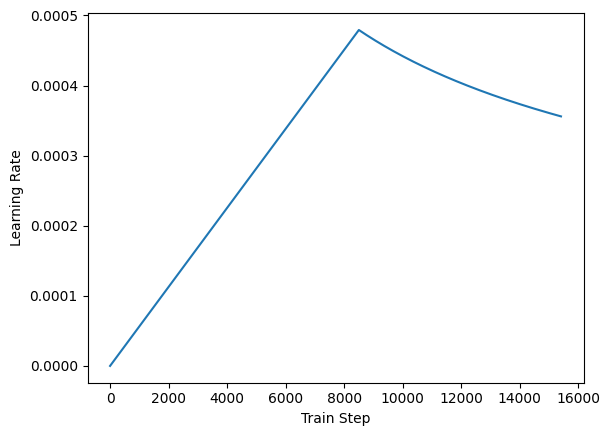

In [33]:
plt.plot(learningrate(tf.range(15412, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [34]:
from time import perf_counter

In [35]:
examples = ["<jj> what are you doing ?",'<cc> what are you doing ?','<gs> what are you doing ?','<jd> what are you doing ?','<kw> what are you doing ?']

In [36]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> what are you doing ?
Predicted translation: 너 뭐 하맨?
Input: <cc> what are you doing ?
Predicted translation: 3는 뭐 하는 겨.
Input: <gs> what are you doing ?
Predicted translation: 니 뭐.
Input: <jd> what are you doing ?
Predicted translation: 뭐 하는 거야 3아.
Input: <kw> what are you doing ?
Predicted translation: 5아 뭐하는 거야?
1.5180557209969265


In [37]:
examples = ["<jj> i like this song .",'<cc> i like this song . ','<gs> i like this song . ','<jd> i like this song . ','<kw> i like this song . ']

In [38]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> i like this song .
Predicted translation: 노래 영 해.
Input: <cc> i like this song . 
Predicted translation: 노래 이케 3아
Input: <gs> i like this song . 
Predicted translation: 노래 이케 3아
Input: <jd> i like this song . 
Predicted translation: 노래 이 ⁇  이렇게 해 갖고 4아
Input: <kw> i like this song . 
Predicted translation: 이참 노래 5아.
1.6438721329977852


In [39]:
examples = ["<jj> Let's do homework together .","<cc> Let's do homework together .","<gs> Let's do homework together .","<jd> Let's do homework together .","<kw> Let's do homework together ."]

In [40]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> Let's do homework together .
Predicted translation: 숙제를 같이 하게.
Input: <cc> Let's do homework together .
Predicted translation: 같이 숙제를 하게 혀.
Input: <gs> Let's do homework together .
Predicted translation: 같이 숙제도 하게 하고예.
Input: <jd> Let's do homework together .
Predicted translation: 같이 숙제를 하게 혀 8아
Input: <kw> Let's do homework together .
Predicted translation: 같이 숙제를 하게 해대다.
1.9338693270001386


In [41]:
examples = ["<jj> Are you going to sleep ?","<cc> Are you going to sleep ?","<gs> Are you going to sleep ?","<jd> Are you going to sleep ?","<kw> Are you going to sleep ?"]

In [42]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> Are you going to sleep ?
Predicted translation: 4이는 잔댄
Input: <cc> Are you going to sleep ?
Predicted translation: 3이는 잔댜.
Input: <gs> Are you going to sleep ?
Predicted translation: 4이 니는 잔다.
Input: <jd> Are you going to sleep ?
Predicted translation: 3이는 잔다매.
Input: <kw> Are you going to sleep ?
Predicted translation: 5이 자게 생겼나?
1.9658051770020393


In [43]:
from datasets import load_metric

bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []

test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
    bleu_valid_score.append(result)

full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:13<00:00,  1.63it/s]


In [44]:
full_data_test.bleu.mean()

15.934493416837858

In [45]:
full_data_test.loc[:,['topic','eng','reg','dial','pred','bleu']].sort_values('bleu', ascending=False).head()

data_dir = os.getenv('HOME')+'/aiffel/s_DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + f'/test_results_{tokenizer_name}16000_final_needs_merge_0601.csv')


KeyError: "['topic'] not in index"

In [ ]:
wandb.finish()